In [24]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)



In [25]:
df = pd.read_csv("StudentPerformanceFactors.csv")
df.head(20)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
5,19,88,Medium,Medium,Yes,8,89,Medium,Yes,3,Medium,Medium,Public,Positive,3,No,Postgraduate,Near,Male,71
6,29,84,Medium,Low,Yes,7,68,Low,Yes,1,Low,Medium,Private,Neutral,2,No,High School,Moderate,Male,67
7,25,78,Low,High,Yes,6,50,Medium,Yes,1,High,High,Public,Negative,2,No,High School,Far,Male,66
8,17,94,Medium,High,No,6,80,High,Yes,0,Medium,Low,Private,Neutral,1,No,College,Near,Male,69
9,23,98,Medium,Medium,Yes,8,71,Medium,Yes,0,High,High,Public,Positive,5,No,High School,Moderate,Male,72


Missing Values

In [26]:
df.isnull().sum()[df.isnull().sum() > 0]

Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64

In [27]:
# Fill in missing Teacher_Quality with the most common value (mode)
df['Teacher_Quality'].fillna(df['Teacher_Quality'].mode()[0], inplace=True)

# Fill in missing Parental_Education_Level with 'Missing'
df['Parental_Education_Level'].fillna('Missing', inplace=True)

# Fill in missing Distance_from_Home with 'Missing'
df['Distance_from_Home'].fillna('Missing', inplace=True)

Standardizing Categorical Values (capitalization,, whitespaces, etc)

In [28]:
categorical_cols = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                    'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                    'School_Type', 'Peer_Influence', 'Learning_Disabilities',
                    'Parental_Education_Level', 'Distance_from_Home', 'Gender']

for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip().str.title()

Encoding Categorical Variables for Regression (Ordinal and Dummy Variables)

In [29]:
# Ordinal encoding: convert ordered categories into numeric values
ordinal_maps = {
    'Teacher_Quality': {'Low': 1, 'Medium': 2, 'High': 3},
    'Motivation_Level': {'Low': 1, 'Medium': 2, 'High': 3},
    'Parental_Involvement': {'Low': 1, 'Medium': 2, 'High': 3},
    'Access_to_Resources': {'Low': 1, 'Medium': 2, 'High': 3},
    'Parental_Education_Level': {'High School': 1, 'College': 2, 'Postgrad': 3, 'Missing': 0},
    'Distance_from_Home': {'Near': 1, 'Moderate': 2, 'Far': 3, 'Missing': 0}
}

for col, mapping in ordinal_maps.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

# Dummy variable encoding: create binary columns for unordered categories
nominal_cols = ['Internet_Access', 'Extracurricular_Activities', 'Family_Income',
                'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Gender']

df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [30]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Teacher_Quality,Physical_Activity,...,Exam_Score,Internet_Access_Yes,Extracurricular_Activities_Yes,Family_Income_Low,Family_Income_Medium,School_Type_Public,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_Yes,Gender_Male
0,23,84,1,3,7,73,1,0,2,3,...,67,1,0,1,0,1,0,1,0,1
1,19,64,1,2,8,59,1,2,2,4,...,61,1,0,0,1,1,0,0,0,0
2,24,98,2,2,7,91,2,2,2,4,...,74,1,1,0,1,1,1,0,0,1
3,29,89,1,2,8,98,2,1,2,4,...,71,1,1,0,1,1,0,0,0,1
4,19,92,2,2,6,65,2,3,3,4,...,70,1,1,0,1,1,1,0,0,0


In [8]:
# Display basic information
df_info = df.info()
df_description = df.describe(include='all')

df_description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Hours_Studied                   6607 non-null   int64  
 1   Attendance                      6607 non-null   int64  
 2   Parental_Involvement            6607 non-null   int64  
 3   Access_to_Resources             6607 non-null   int64  
 4   Sleep_Hours                     6607 non-null   int64  
 5   Previous_Scores                 6607 non-null   int64  
 6   Motivation_Level                6607 non-null   int64  
 7   Tutoring_Sessions               6607 non-null   int64  
 8   Teacher_Quality                 6607 non-null   int64  
 9   Physical_Activity               6607 non-null   int64  
 10  Parental_Education_Level        5302 non-null   float64
 11  Distance_from_Home              6607 non-null   int64  
 12  Exam_Score                      66

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Teacher_Quality,Physical_Activity,...,Exam_Score,Internet_Access_Yes,Extracurricular_Activities_Yes,Family_Income_Low,Family_Income_Medium,School_Type_Public,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_Yes,Gender_Male
count,6607.000000,6607.000000,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,...,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,2.086423,2.100197,7.02906,75.070531,1.906463,1.493719,2.195247,2.967610,...,67.235659,0.924474,0.596035,0.404420,0.403511,0.695929,0.392311,0.399273,0.105191,0.577267
std,5.990594,11.547475,0.695521,0.698347,1.46812,14.399784,0.695798,1.230570,0.596707,1.031231,...,3.890456,0.264258,0.490728,0.490817,0.490639,0.460048,0.488302,0.489786,0.306823,0.494031
min,1.000000,60.000000,1.000000,1.000000,4.00000,50.000000,1.000000,0.000000,1.000000,0.000000,...,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,70.000000,2.000000,2.000000,6.00000,63.000000,1.000000,1.000000,2.000000,2.000000,...,65.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,80.000000,2.000000,2.000000,7.00000,75.000000,2.000000,1.000000,2.000000,3.000000,...,67.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,24.000000,90.000000,3.000000,3.000000,8.00000,88.000000,2.000000,2.000000,3.000000,4.000000,...,69.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,44.000000,100.000000,3.000000,3.000000,10.00000,100.000000,3.000000,8.000000,3.000000,6.000000,...,101.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


La'Tahvia EA Data Visualizations

In [31]:
column_rename_map = {
    'Hours_Studied': 'Hours Studied',
    'Attendance': 'Attendance (%)',
    'Parental_Involvement': 'Parental Involvement',
    'Access_to_Resources': 'Access to Resources',
    'Sleep_Hours': 'Sleep Hours',
    'Previous_Scores': 'Previous Scores',
    'Motivation_Level': 'Motivation Level',
    'Tutoring_Sessions': 'Tutoring Sessions',
    'Teacher_Quality': 'Teacher Quality',
    'Physical_Activity': 'Physical Activity (hrs/week)',
    'Parental_Education_Level': 'Parental Education Level',
    'Distance_from_Home': 'Distance from Home (km)',
    'Exam_Score': 'Exam Score',
    'Internet_Access_Yes': 'Has Internet Access',
    'Extracurricular_Activities_Yes': 'In Extracurricular Activities',
    'Family_Income_Low': 'Low Family Income',
    'Family_Income_Medium': 'Medium Family Income',
    'School_Type_Public': 'Public School',
    'Peer_Influence_Neutral': 'Neutral Peer Influence',
    'Peer_Influence_Positive': 'Positive Peer Influence',
    'Learning_Disabilities_Yes': 'Has Learning Disabilities',
    'Gender_Male': 'Male Student'
}

df.rename(columns=column_rename_map, inplace=True)

df


,Hours Studied,Attendance (%),Parental Involvement,Access to Resources,Sleep Hours,Previous Scores,Motivation Level,Tutoring Sessions,Teacher Quality,Physical Activity (hrs/week),...,Exam Score,Has Internet Access,In Extracurricular Activities,Low Family Income,Medium Family Income,Public School,Neutral Peer Influence,Positive Peer Influence,Has Learning Disabilities,Male Student
0,23,84,1,3,7,73,1,0,2,3,...,67,1,0,1,0,1,0,1,0,1
1,19,64,1,2,8,59,1,2,2,4,...,61,1,0,0,1,1,0,0,0,0
2,24,98,2,2,7,91,2,2,2,4,...,74,1,1,0,1,1,1,0,0,1
3,29,89,1,2,8,98,2,1,2,4,...,71,1,1,0,1,1,0,0,0,1
4,19,92,2,2,6,65,2,3,3,4,...,70,1,1,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,3,2,7,76,2,1,2,2,...,68,1,0,0,0,1,0,1,0,0
6603,23,76,3,2,8,81,2,3,3,2,...,69,1,0,1,0,1,0,1,0,0
6604,20,90,2,1,6,65,1,3,2,2,...,68,1,1,1,0,1,0,0,0,0
6605,10,86,3,3,6,91,3,2,2,3,...,68,1,1,1,0,0,0,1,0,0


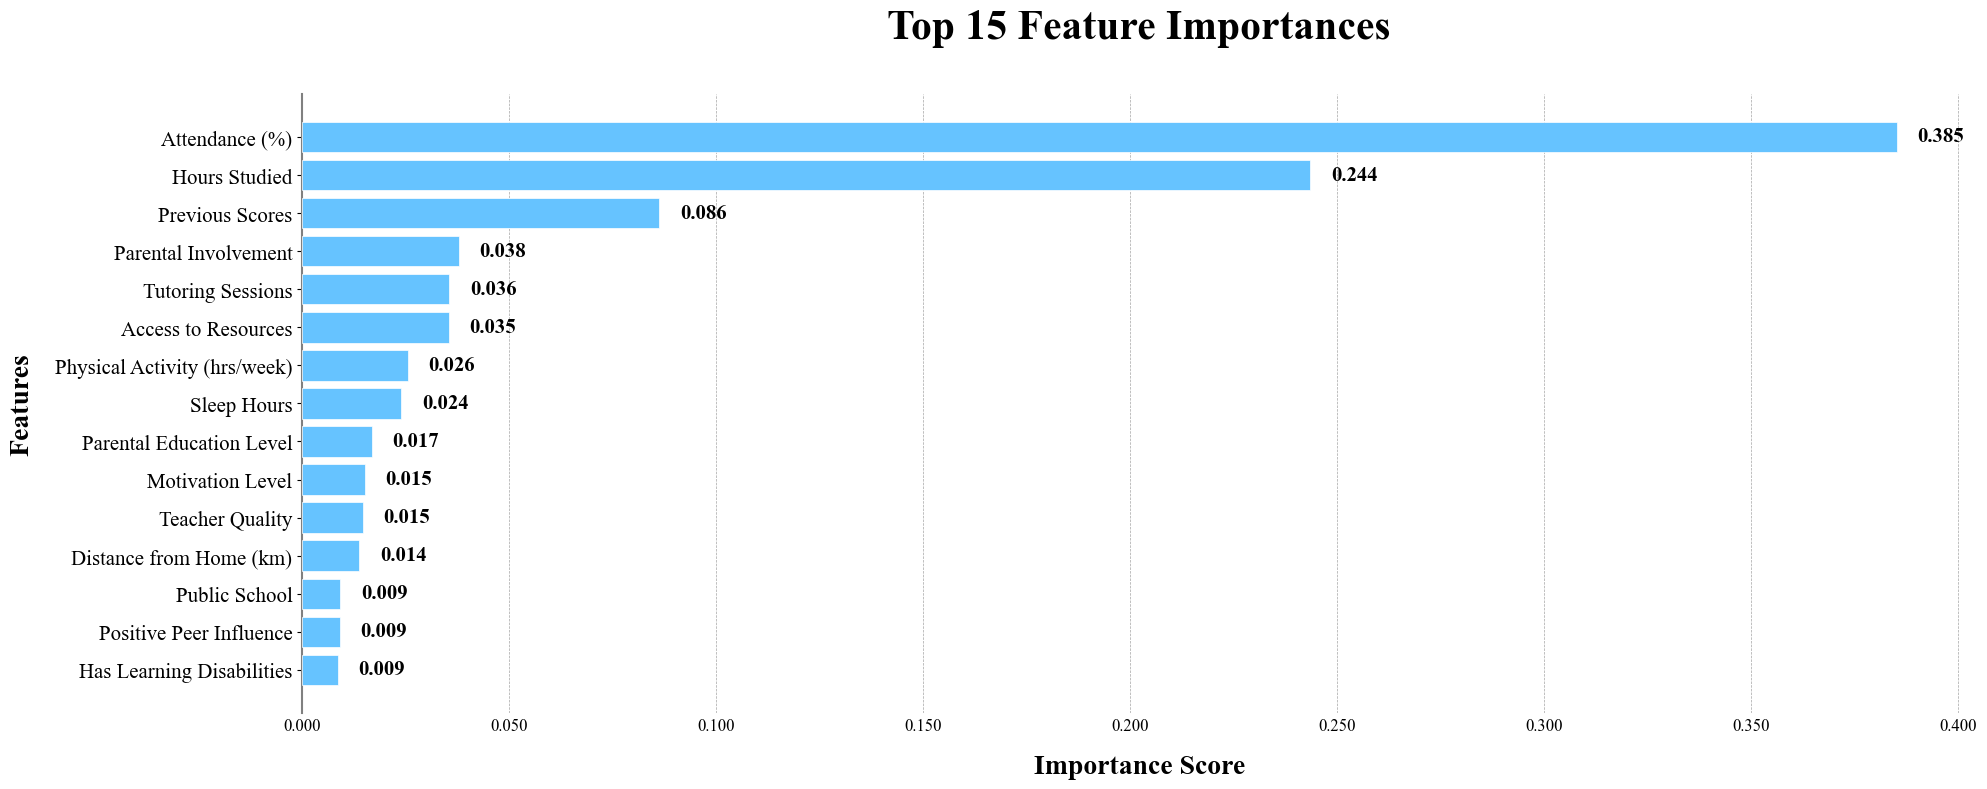

In [32]:
# Graph Styling
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Prepare data
X = df.drop(columns='Exam Score')
y = df['Exam Score']

# Fit Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Compute importances and select top 15
importances = pd.Series(model.feature_importances_, index=X.columns)
top_importances = importances.nlargest(15)[::-1]

# Figure & axis
fig, ax = plt.subplots(figsize=(20, 8), dpi=100)

# Horizontal bars
bars = ax.barh(
    top_importances.index,
    top_importances.values,
    color='#66C3FF',   
    edgecolor='white',
    linewidth=0.5,
    zorder=3
)

# Vertical gridlines
ax.xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7, zorder=0)

# Style spines: show only left
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('gray')

# Titles and labels
ax.set_title(
    "Top 15 Feature Importances",
    loc='center',
    fontweight='bold',
    fontsize=30,
    pad=40
)
ax.set_xlabel(
    "Importance Score",
    fontsize=20,
    fontweight='bold',
    labelpad=15
)
ax.set_ylabel(
    "Features",
    fontsize=20,
    fontweight='bold',
    labelpad=15
    )

# Tick
ax.tick_params(axis='x', which='major', length=0, labelsize=12)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.3f}'))
ax.tick_params(axis='y', labelsize=15)

# Bars with values
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va='center',
        fontsize=15,
        fontweight='bold'
    )

# Margins
fig.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.15)
plt.tight_layout()
plt.show()


In [33]:
# Top 5 feature stats

group_stats1 = df.groupby('Attendance (%)')['Exam Score'].describe()
display(group_stats1)

group_stats2 = df.groupby('Hours Studied')['Exam Score'].describe()
display(group_stats2)


group_stats3 = df.groupby('Previous Scores')['Exam Score'].describe()
display(group_stats3)

group_stats4 = df.groupby('Parental Involvement')['Exam Score'].describe()
display(group_stats4)

group_stats5 = df.groupby('Tutoring Sessions')['Exam Score'].describe()
display(group_stats5)

,count,mean,std,min,25%,50%,75%,max
Attendance (%),,,,,,,,
60,87.0,62.413793,2.461573,57.0,61.00,63.0,64.0,68.0
61,164.0,63.384146,3.321984,58.0,61.00,63.0,65.0,82.0
62,152.0,63.756579,3.132814,55.0,62.00,64.0,65.0,88.0
63,155.0,64.361290,3.176382,58.0,62.00,64.0,66.0,86.0
64,182.0,63.884615,2.516879,57.0,62.00,64.0,66.0,70.0
65,158.0,63.905063,2.619836,56.0,62.00,64.0,65.0,80.0
66,145.0,64.537931,2.826022,57.0,63.00,64.0,66.0,84.0
67,190.0,64.626316,3.404377,57.0,63.00,65.0,66.0,95.0
68,170.0,65.147059,2.458319,59.0,64.00,65.0,67.0,78.0


,count,mean,std,min,25%,50%,75%,max
Hours Studied,,,,,,,,
1,3.0,71.000000,18.193405,60.0,60.50,61.0,76.50,92.0
2,6.0,63.000000,2.966479,58.0,62.00,63.5,65.00,66.0
3,12.0,61.333333,4.097301,55.0,58.00,61.5,65.25,67.0
4,17.0,61.647059,3.315516,58.0,59.00,61.0,64.00,69.0
5,21.0,62.857143,3.004758,56.0,61.00,63.0,65.00,68.0
6,17.0,63.470588,2.786522,58.0,61.00,64.0,65.00,68.0
7,51.0,64.352941,5.403049,57.0,62.00,64.0,66.00,87.0
8,58.0,64.155172,3.007603,59.0,62.00,63.5,67.00,70.0
9,86.0,64.162791,3.213429,57.0,62.00,64.0,66.00,82.0


,count,mean,std,min,25%,50%,75%,max
Previous Scores,,,,,,,,
50,62.0,65.516129,2.973886,60.0,63.25,65.0,68.00,72.0
51,126.0,65.912698,3.261950,58.0,64.00,66.0,68.00,73.0
52,136.0,66.875000,4.564659,58.0,64.00,67.0,69.00,92.0
53,144.0,66.270833,4.078288,58.0,64.00,66.0,69.00,86.0
54,136.0,66.220588,4.857512,59.0,63.00,66.0,68.00,95.0
55,124.0,66.096774,3.982521,58.0,63.00,66.0,68.00,87.0
56,120.0,66.416667,4.233884,60.0,64.00,66.0,68.00,93.0
57,125.0,66.872000,3.505700,58.0,65.00,67.0,69.00,84.0
58,120.0,66.641667,3.970047,58.0,64.00,66.0,69.00,89.0


,count,mean,std,min,25%,50%,75%,max
Parental Involvement,,,,,,,,
1,1337.0,66.358265,3.971398,56.0,64.0,66.0,69.0,101.0
2,3362.0,67.098156,3.727620,55.0,65.0,67.0,69.0,97.0
3,1908.0,68.092767,3.947650,57.0,66.0,68.0,70.0,100.0


,count,mean,std,min,25%,50%,75%,max
Tutoring Sessions,,,,,,,,
0,1513.0,66.489755,3.881009,56.0,64.00,66.0,69.00,98.0
1,2179.0,66.980266,3.854574,55.0,65.00,67.0,69.00,99.0
2,1649.0,67.567010,3.851053,58.0,65.00,67.0,70.00,98.0
3,836.0,67.894737,3.646791,58.0,66.00,68.0,70.00,100.0
4,301.0,68.229236,3.651111,59.0,66.00,68.0,70.00,99.0
5,103.0,69.067961,4.779987,60.0,66.00,69.0,71.00,101.0
6,18.0,71.666667,4.200840,64.0,67.75,72.5,74.75,78.0
7,7.0,69.857143,4.099942,63.0,68.00,71.0,72.00,75.0
8,1.0,69.000000,NaN,69.0,69.00,69.0,69.00,69.0


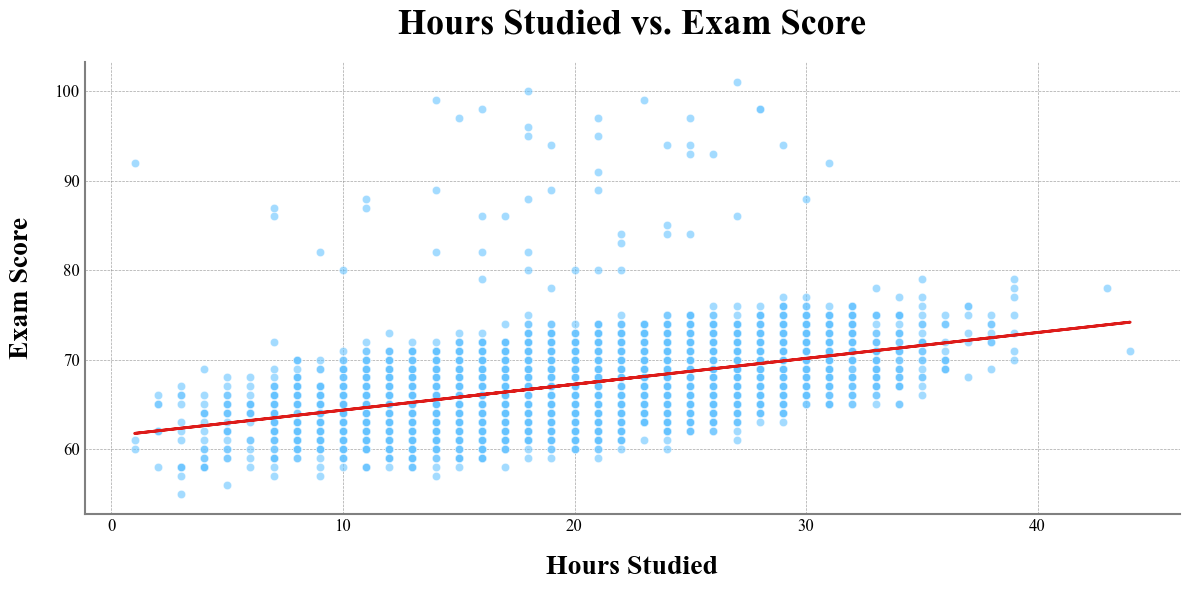

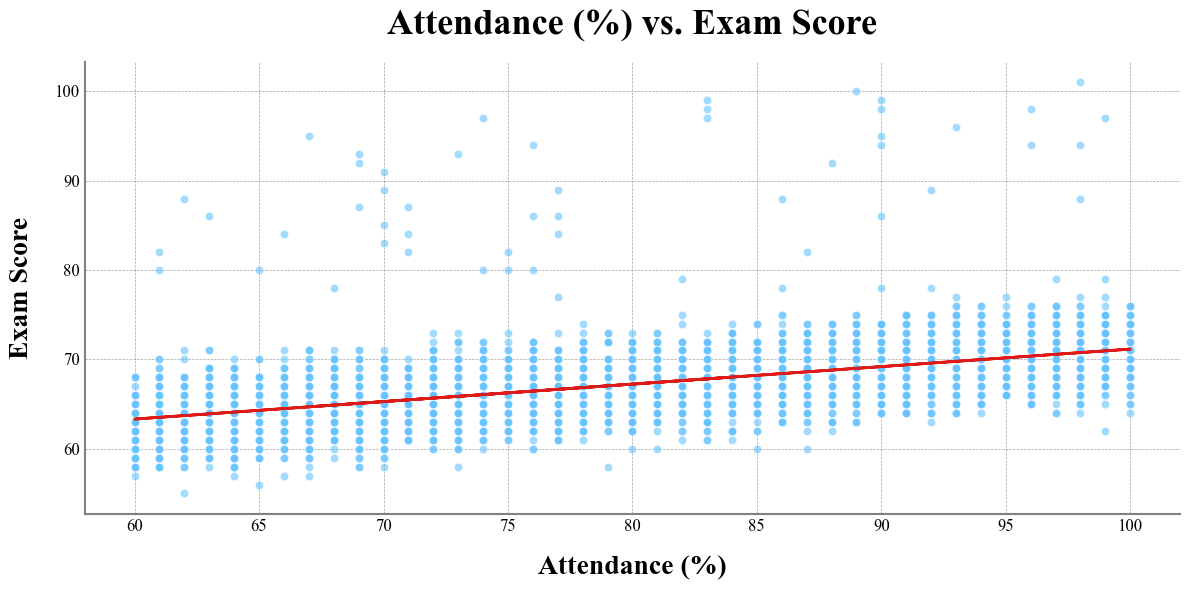

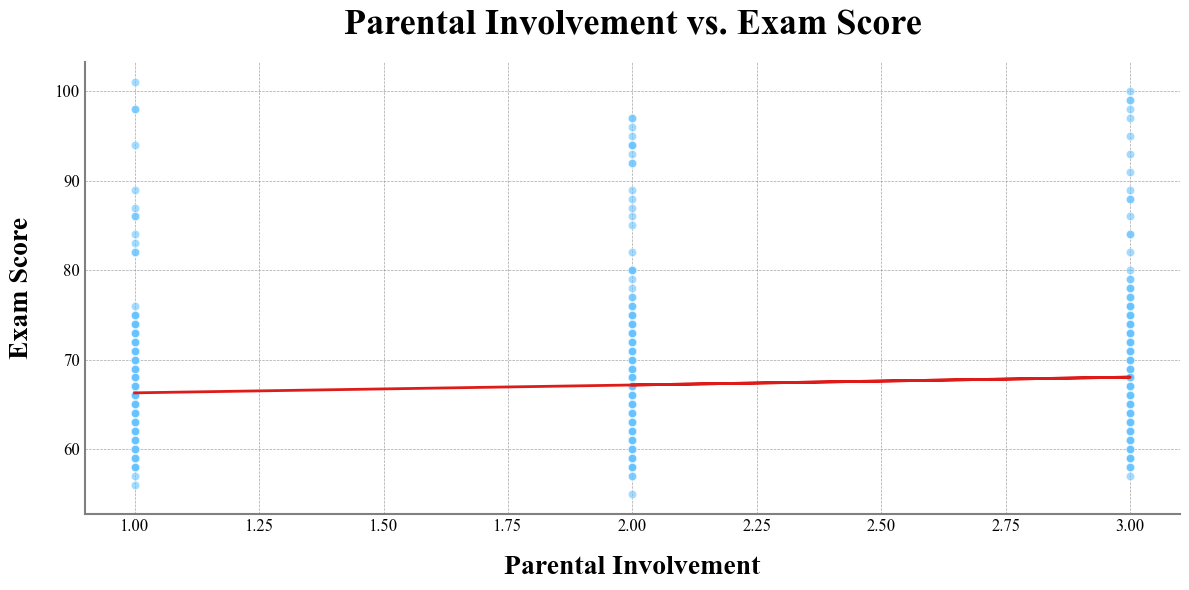

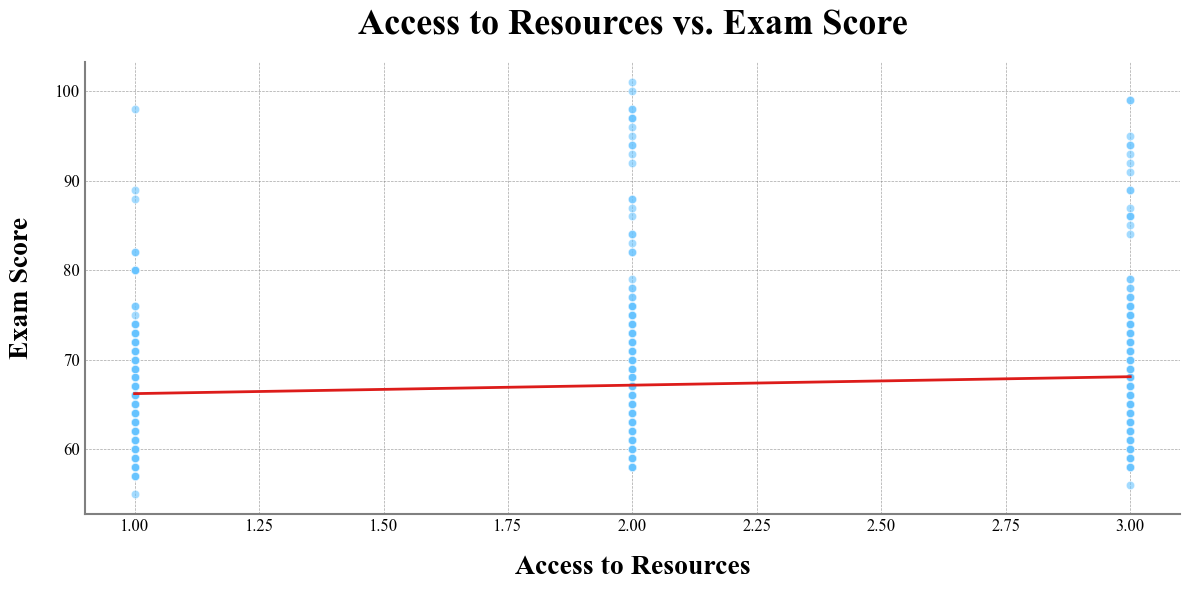

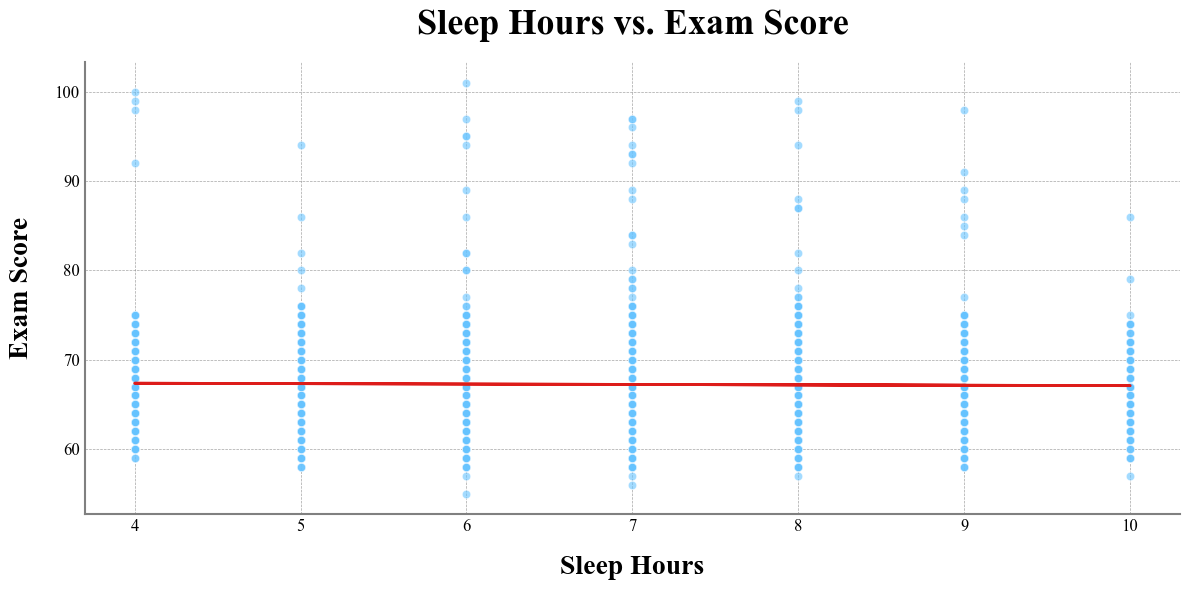

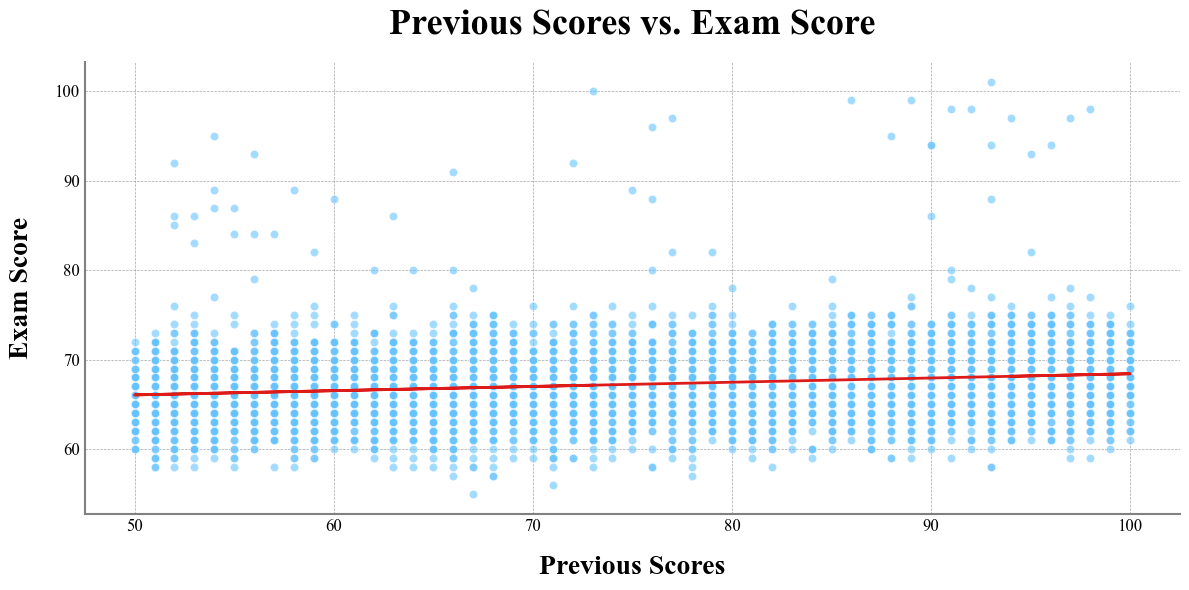

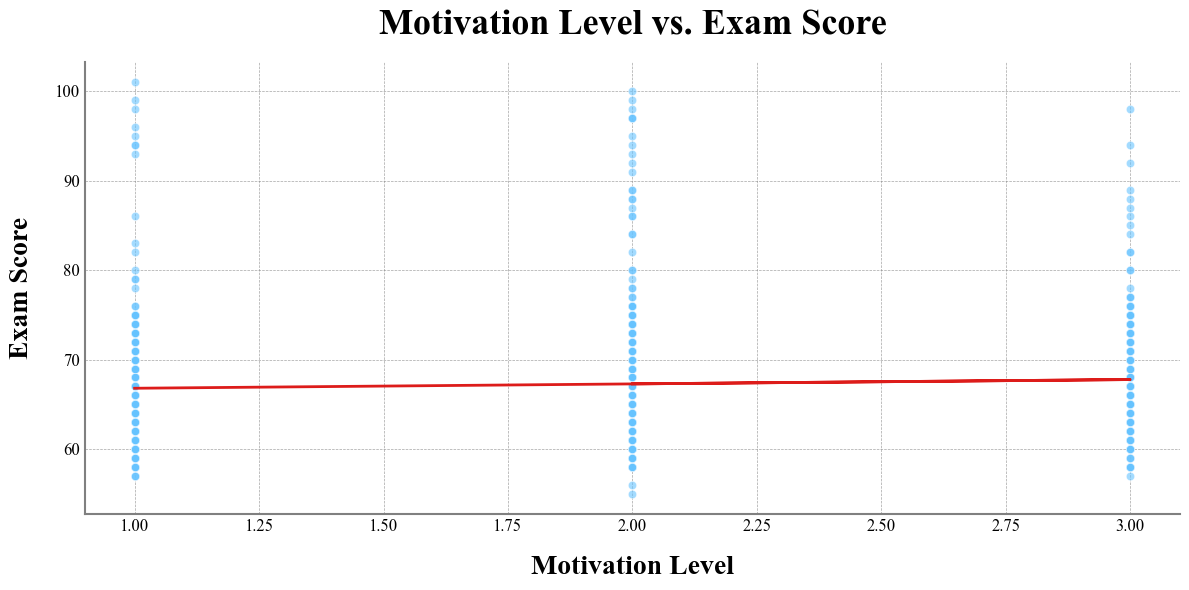

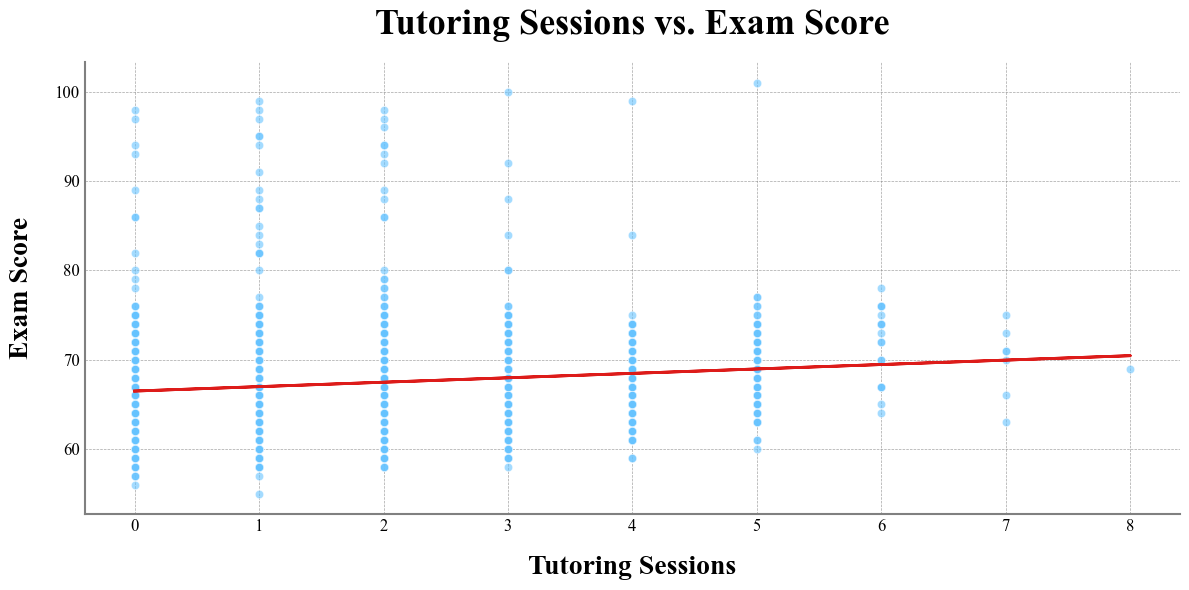

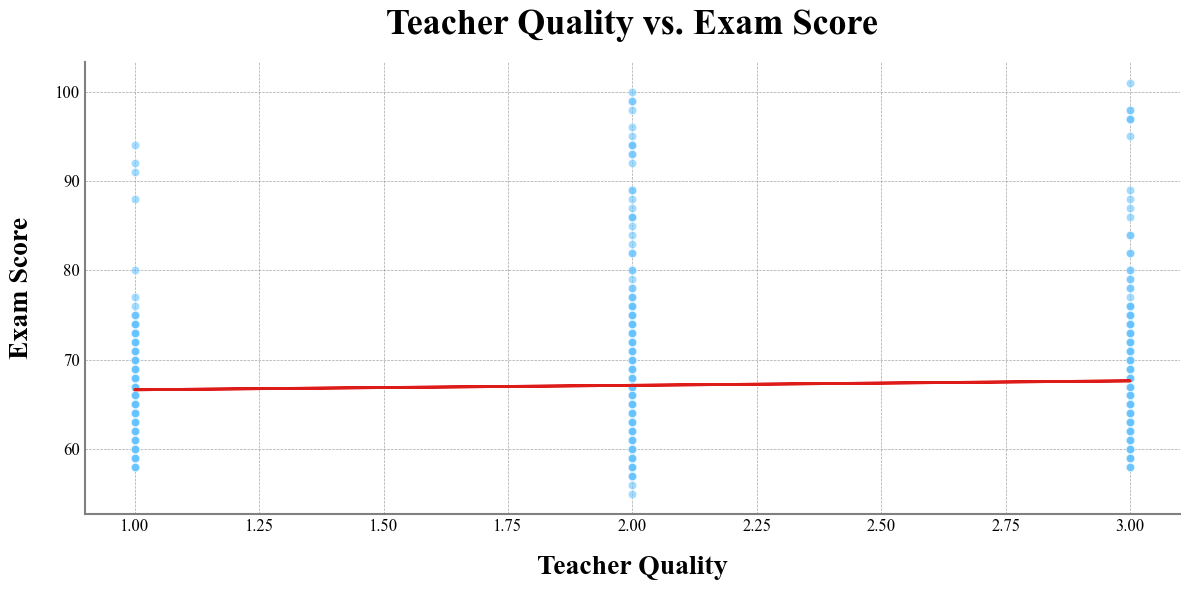

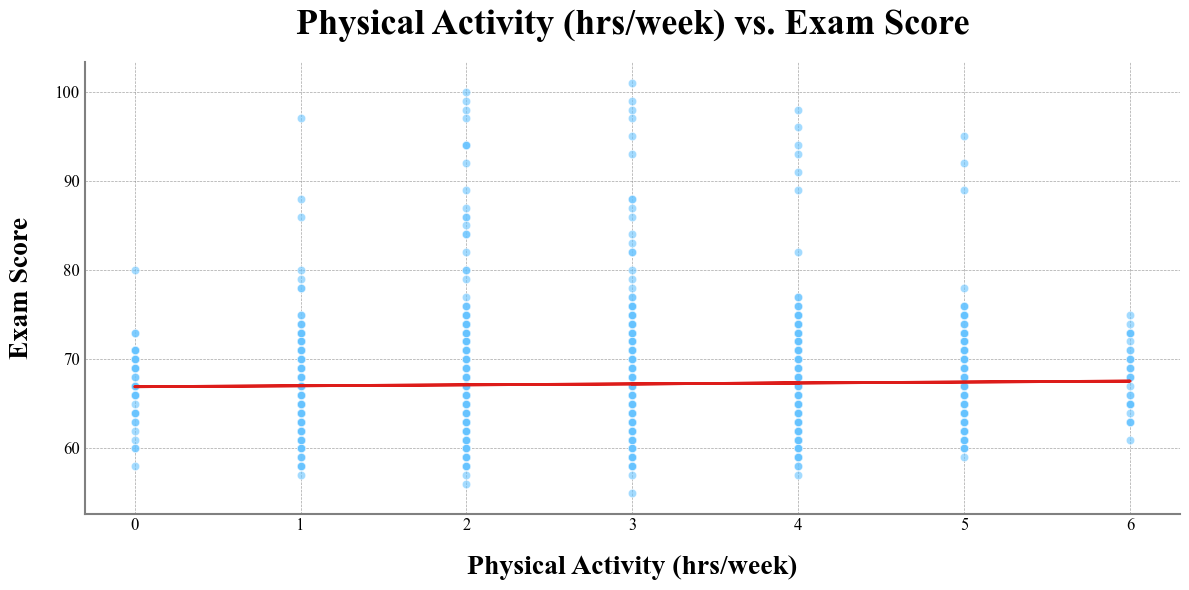

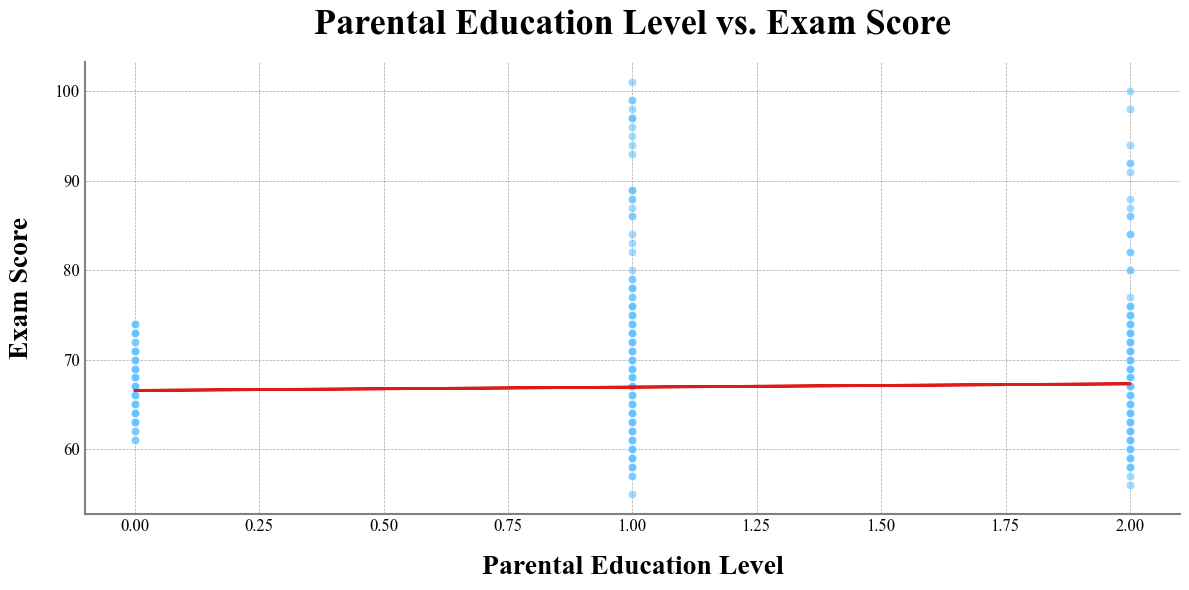

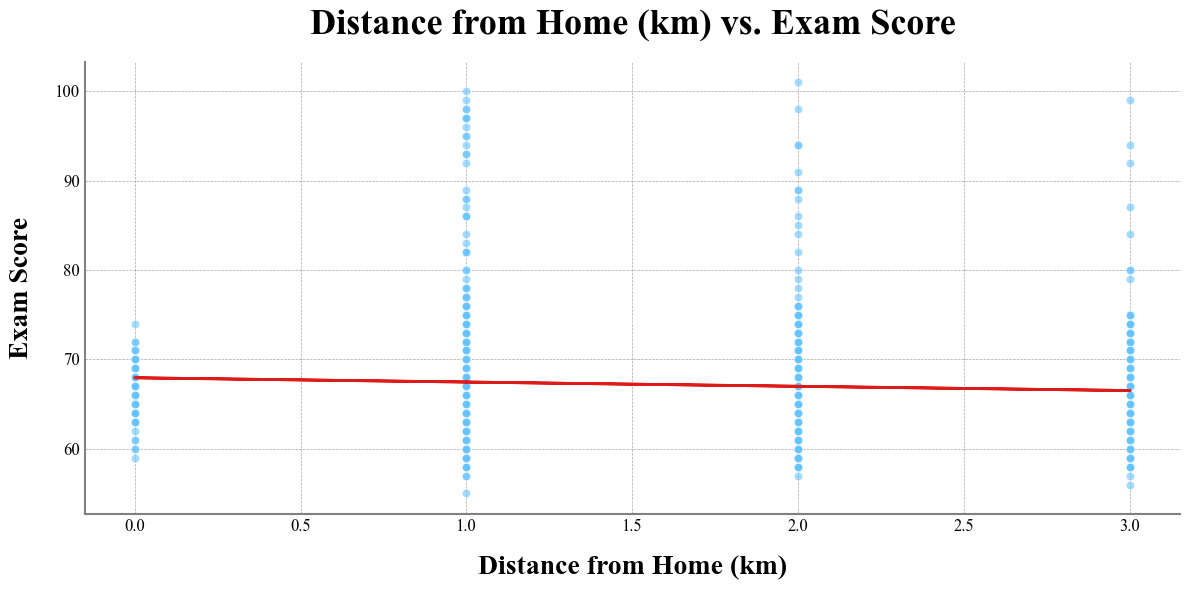

In [34]:
# Numeric Columns
numeric_cols = [
    'Hours Studied', 'Attendance (%)', 'Parental Involvement', 'Access to Resources', 'Sleep Hours', 'Previous Scores', 'Motivation Level', 'Tutoring Sessions',
    'Teacher Quality', 'Physical Activity (hrs/week)', 'Parental Education Level','Distance from Home (km)'
]

# Graph Styling
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Loop through each numeric feature
for col in numeric_cols:
    # Scatter plot for each
    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

    # Plot scatter points
    ax.scatter(
        df[col],
        df['Exam Score'],
        color='#66C3FF',
        alpha=0.6,
        edgecolor='white',
        linewidth=0.5,
        zorder=3
    )

    # Fit and plot regression line
    mask = df[col].notna() & df['Exam Score'].notna()
    x = df.loc[mask, col]
    y = df.loc[mask, 'Exam Score']
    m, b = np.polyfit(x, y, 1)
    ax.plot(
        x, m * x + b,
        color='#DD1C1A',
        linewidth=2,
        zorder=4
    )

    # Titles and labels
    ax.set_title(
        f"{col} vs. Exam Score",
        loc='center',
        fontweight='bold',
        fontsize=26,
        pad=20
    )
    ax.set_xlabel(
        col.replace('_', ' '),
        fontsize=20,
        fontweight='bold',
        labelpad=15
    )
    ax.set_ylabel(
        'Exam Score',
        fontsize=20,
        fontweight='bold',
        labelpad=15
    )

    # Grid and spines
    ax.xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7, zorder=0)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7, zorder=0)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['left'].set_color('gray')

    # Tick styling
    ax.tick_params(axis='x', which='major', length=0, labelsize=12)
    ax.tick_params(axis='y', which='major', length=0, labelsize=12)

    # Margins and layout
    fig.subplots_adjust(left=0.12, right=0.95, top=0.90, bottom=0.12)
    plt.tight_layout()
    plt.show()


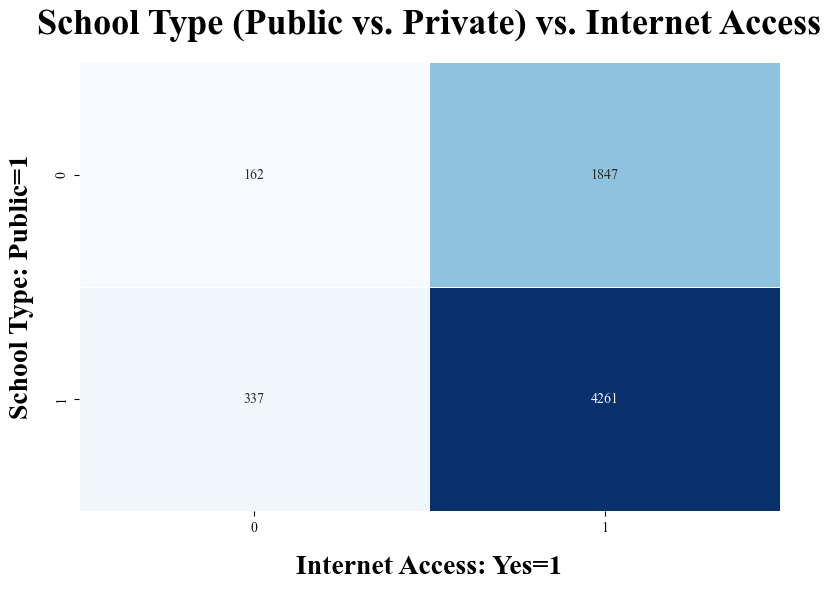

In [35]:
# Graph styling
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Pivot table heatmap: School Type vs. Internet Access
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ct = pd.crosstab(df['Public School'], df['Has Internet Access'])
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, linewidths=0.5, linecolor='white')
ax.set_title('School Type (Public vs. Private) vs. Internet Access', loc='center', fontweight='bold', fontsize=26, pad=20)
ax.set_xlabel('Internet Access: Yes=1', fontsize=20, fontweight='bold', labelpad=15)
ax.set_ylabel('School Type: Public=1', fontsize=20, fontweight='bold', labelpad=15)

# Style spines
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Margins & layout
fig.subplots_adjust(left=0.15, right=0.95, top=0.90, bottom=0.15)
plt.tight_layout()
plt.show()


In [36]:
# Prepare data
X = df.drop(columns=['Exam Score'])  
y = df['Exam Score']             

X = X.fillna(X.mean(numeric_only=True))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# Lasso Cross-Validation
lasso_cv = LassoCV(alphas=np.logspace(-2, 2, 100), cv=5, max_iter=10000)
lasso_cv.fit(X_scaled, y)
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha: {optimal_alpha:.4f}")

lasso_final = LassoCV(alphas=[optimal_alpha], cv=5, max_iter=10000)
lasso_final.fit(X_scaled, y)

coef_mask = lasso_final.coef_ != 0
selected_features = X.columns[coef_mask].tolist()
print("Selected features after Lasso:", selected_features)

Optimal alpha: 0.0100
Selected features after Lasso: ['Hours Studied', 'Attendance (%)', 'Parental Involvement', 'Access to Resources', 'Previous Scores', 'Motivation Level', 'Tutoring Sessions', 'Teacher Quality', 'Physical Activity (hrs/week)', 'Parental Education Level', 'Distance from Home (km)', 'Has Internet Access', 'In Extracurricular Activities', 'Low Family Income', 'Medium Family Income', 'Neutral Peer Influence', 'Positive Peer Influence', 'Has Learning Disabilities', 'Male Student']


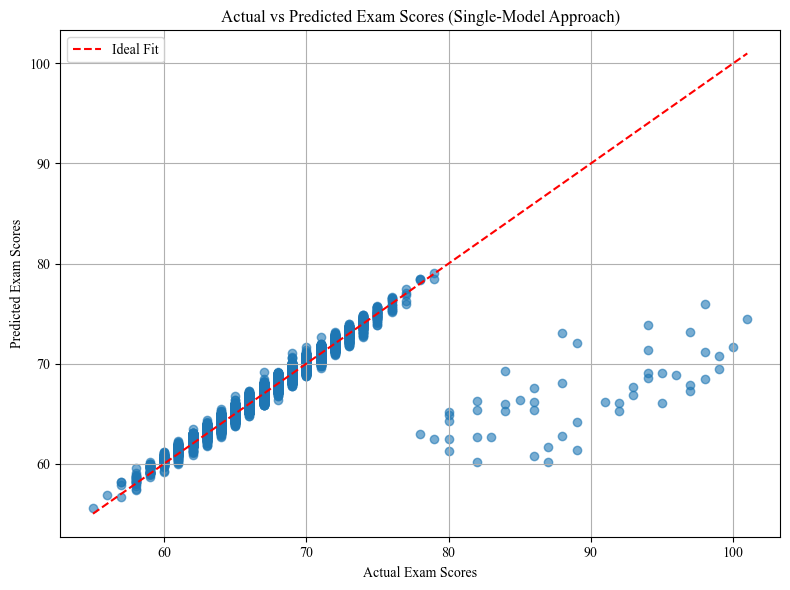

R² for All Scores (Unified Model): 0.7198


In [38]:
X_selected = X[selected_features]
scaler_all = StandardScaler()
X_scaled_all = scaler_all.fit_transform(X_selected)

# Fit single regression model
model_all = LinearRegression()
model_all.fit(X_scaled_all, y)

# Predict using the unified model
y_pred_all = model_all.predict(X_scaled_all)

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_all, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Exam Scores")
plt.ylabel("Predicted Exam Scores")
plt.title("Actual vs Predicted Exam Scores (Single-Model Approach)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Compute R-squared
r2_all = r2_score(y, y_pred_all)
print(f"R² for All Scores (Unified Model): {r2_all:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have v

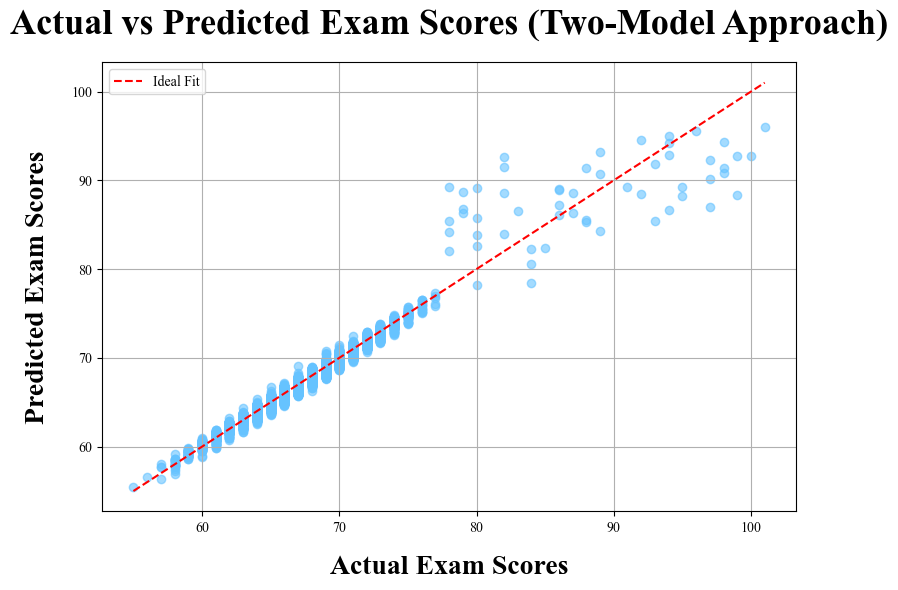

Combined R-squared: 0.9680
R² Low Scores (≤ 77): 0.9797
R² High Scores (> 77): 0.3641


In [39]:
# Drop nan values
X_selected = X_selected.dropna()
y = y.loc[X_selected.index]

# Threshold to split data into low and high exam score groups
threshold = 77
low_mask = y <= threshold
high_mask = y > threshold

# Split the feature data and target variable based on the threshold
X_low = X_selected[low_mask]
y_low = y[low_mask]
X_high = X_selected[high_mask]
y_high = y[high_mask]

# Standardize the features
scaler_low = StandardScaler()
X_low_scaled = scaler_low.fit_transform(X_low)

scaler_high = StandardScaler()
X_high_scaled = scaler_high.fit_transform(X_high)

# Train models
model_low = LinearRegression()
model_low.fit(X_low_scaled, y_low)

model_high = LinearRegression()
model_high.fit(X_high_scaled, y_high)

# Predict
y_pred_combined = []
for i in range(len(X_selected)):
    x = X_selected.iloc[i].values.reshape(1, -1)
    if y.iloc[i] > threshold:
        x_scaled = scaler_high.transform(x)
        pred = model_high.predict(x_scaled)[0]
    else:
        x_scaled = scaler_low.transform(x)
        pred = model_low.predict(x_scaled)[0]
    y_pred_combined.append(pred)

# Plot actual vs predicted exam scores
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y, y_pred_combined, alpha=0.6, color='#66C3FF')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Ideal Fit")

ax.set_title(
    "Actual vs Predicted Exam Scores (Two-Model Approach)",
    loc='center',
    fontweight='bold',
    fontsize=26,
    pad=20
)
ax.set_xlabel("Actual Exam Scores", fontsize=20, fontweight='bold', labelpad=15)
ax.set_ylabel("Predicted Exam Scores", fontsize=20, fontweight='bold', labelpad=15)

ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

# R²
r2_total = r2_score(y, y_pred_combined)
print(f"Combined R-squared: {r2_total:.4f}")

# R² for models
r2_low = r2_score(y_low, model_low.predict(X_low_scaled))
r2_high = r2_score(y_high, model_high.predict(X_high_scaled))
print(f"R² Low Scores (≤ {threshold}): {r2_low:.4f}")
print(f"R² High Scores (> {threshold}): {r2_high:.4f}")

In [40]:
def print_equation(model, features, name="Model"):
    intercept = model.intercept_
    coefs = model.coef_
    equation = f"{name}:\nExam Score = {intercept:.3f}"
    for feat, coef in zip(features, coefs):
        sign = " + " if coef >= 0 else " - "
        equation += f"{sign}{abs(coef):.3f}*{feat}"
    print(equation + "\n")

print_equation(model_low, selected_features, name="Low Score Model (≤ 80)")
print_equation(model_high, selected_features, name="High Score Model (> 80)")

Low Score Model (≤ 80):
Exam Score = 67.059 + 1.781*Hours Studied + 2.318*Attendance (%) + 0.687*Parental Involvement + 0.695*Access to Resources + 0.710*Previous Scores + 0.349*Motivation Level + 0.616*Tutoring Sessions + 0.300*Teacher Quality + 0.234*Physical Activity (hrs/week) + 0.195*Parental Education Level - 0.325*Distance from Home (km) + 0.269*Has Internet Access + 0.245*In Extracurricular Activities - 0.483*Low Family Income - 0.238*Medium Family Income + 0.250*Neutral Peer Influence + 0.499*Positive Peer Influence - 0.308*Has Learning Disabilities - 0.003*Male Student

High Score Model (> 80):
Exam Score = 88.236 - 3.099*Hours Studied + 2.674*Attendance (%) - 0.047*Parental Involvement + 0.521*Access to Resources + 1.542*Previous Scores + 0.108*Motivation Level - 0.470*Tutoring Sessions - 1.028*Teacher Quality + 0.890*Physical Activity (hrs/week) - 0.122*Parental Education Level + 0.134*Distance from Home (km) - 1.106*Has Internet Access - 0.894*In Extracurricular Activities

In [41]:

from sklearn.metrics import classification_report, confusion_matrix

# Threshold and X, y
threshold = 77
X = df[selected_features].copy().fillna(df[selected_features].mean(numeric_only=True))
y = (df['Exam Score'] > threshold).astype(int)


# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Logistic regression
model = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Cross‐val
cv_scores = cross_val_score(model, scaler.transform(X), y, cv=5, scoring='f1_macro')
print(f"5-fold F1-macro: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Predict
y_pred = model.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

5-fold F1-macro: 0.395 ± 0.007

Classification Report:
              precision    recall  f1-score   support

           0      0.995     0.633     0.774      1972
           1      0.007     0.455     0.014        11

    accuracy                          0.632      1983
   macro avg      0.501     0.544     0.394      1983
weighted avg      0.990     0.632     0.770      1983

Confusion Matrix:
[[1249  723]
 [   6    5]]



Test ROC AUC: 0.393


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


<Figure size 600x600 with 0 Axes>

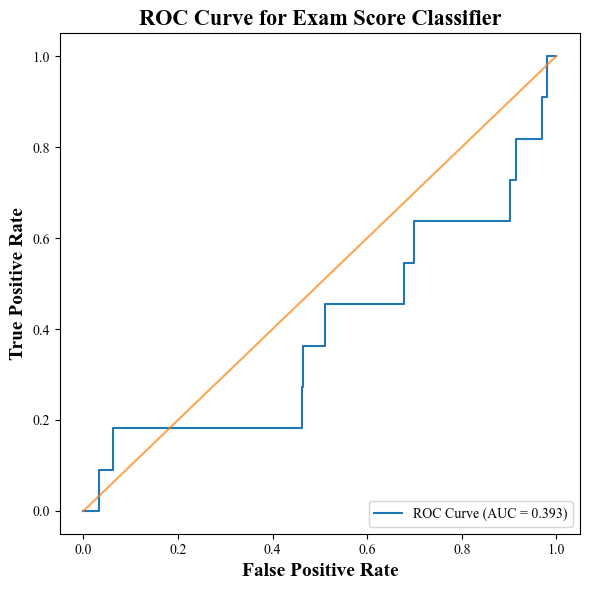

In [21]:
# ROC AUC 
y_proba = model.predict_proba(X_test)[:, 1]
auc     = roc_auc_score(y_test, y_proba)
print(f"\nTest ROC AUC: {auc:.3f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], alpha=0.7)

plt.title("ROC Curve for Exam Score Classifier", fontsize=16, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=14, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=14, fontweight='bold')

plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
